In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
batch_size = 128
train_dataset_FMNIST = datasets.FashionMNIST(root='.', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset_FMNIST = datasets.FashionMNIST(root='.', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader_FMNIST = torch.utils.data.DataLoader(dataset=train_dataset_FMNIST,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader_FMNIST = torch.utils.data.DataLoader(dataset=test_dataset_FMNIST,
                                          batch_size=batch_size,
                                          shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class TrainNet():
    def __init__(self, model, optimizer, batchsize, train_set, test_set, train_loader, test_loader, scheduler, is_sam):
        self.model = model
        self.optimizer = optimizer
        self.batchsize = batchsize

        self.train_dataset = train_set
        self.test_dataset = test_set
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.scheduler = scheduler

        self.is_sam = is_sam

    def train_epoch(self):
        loss_log, acc_log = [], []
        self.model.train()
        for batch_num, (x_batch, y_batch) in enumerate(self.train_loader):
            data = x_batch.cuda()
            target = y_batch.cuda()

            self.optimizer.zero_grad()
            output = self.model(data)
            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = nn.CrossEntropyLoss()(output, target).cpu()
            loss.backward()

            loss_log.append(loss.item())

            if self.is_sam:
                def closure():
                    self.optimizer.zero_grad()
                    output = self.model(data)
                    loss = nn.CrossEntropyLoss()(output, target)
                    loss.backward()
                    return loss
                self.optimizer.step(closure)
            else:
                self.optimizer.step()
        
        return loss_log, acc_log  

    def test(self):
        loss_log, acc_log = [], []
        self.model.eval()
        for batch_num, (x_batch, y_batch) in enumerate(self.test_loader):    
            data = x_batch.cuda()
            target = y_batch.cuda()

            output = self.model(data)
            loss = nn.CrossEntropyLoss()(output, target).cpu()

            pred = torch.max(output, 1)[1].cpu()
            acc = torch.eq(pred, y_batch).float().mean()
            acc_log.append(acc)
            
            loss = loss.item()
            loss_log.append(loss)
        return loss_log, acc_log

    def plot_history(self, train_history, val_history, title='loss'):
        plt.figure()
        plt.title('{}'.format(title))
        plt.plot(train_history, label='train', zorder=1)
        
        points = np.array(val_history)
        
        plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
        plt.xlabel('train steps')
        
        plt.legend(loc='best')
        plt.grid()

        plt.show()
        
    def train(self, n_epochs):
        train_log, train_acc_log = [], []
        val_log, val_acc_log = [], []

        for epoch in range(n_epochs):
            print("Epoch {0} of {1}".format(epoch, n_epochs))
            
            train_loss, train_acc = self.train_epoch()
            self.scheduler.step()

            val_loss, val_acc = self.test()

            train_log.extend(train_loss)
            train_acc_log.extend(train_acc)

            steps = len(self.train_dataset) / self.batchsize
            val_log.append((steps * (epoch + 1), np.mean(val_loss)))
            val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
            
            clear_output()
            self.plot_history(train_log, val_log)    
            self.plot_history(train_acc_log, val_acc_log, title='accuracy')   
            
            print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(np.mean(val_loss), np.mean(val_acc), epoch))


In [ ]:
# https://github.com/davda54/sam

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [ ]:
class ConvNetFMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1,10,5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(10,16,3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], 1, 28, 28)
        seq_out = self.features.forward(x)
        seq_out = seq_out.view(-1, 4 * 4 * 16)
        out = self.classifier(seq_out)
        return F.log_softmax(out, dim=-1)

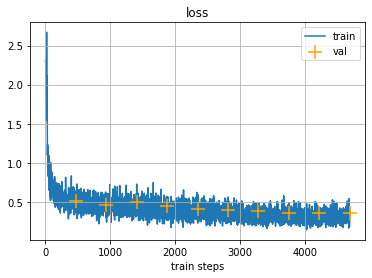

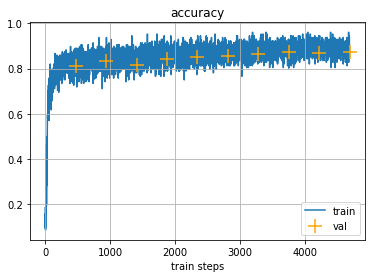

Epoch: 9, val loss: 0.35432715676253357, val accuracy: 0.8730221390724182


In [ ]:
model_sgd = ConvNetFMNIST()
sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sgd, T_max=9)
train_fmnist_sgd = TrainNet(model_sgd, sgd, batch_size, train_dataset_FMNIST, test_dataset_FMNIST, train_loader_FMNIST, test_loader_FMNIST, scheduler, False)

train_fmnist_sgd.train(10)

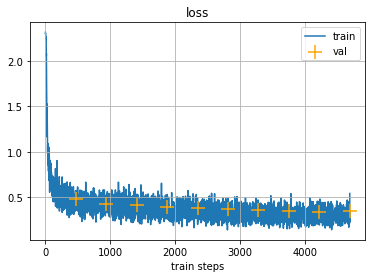

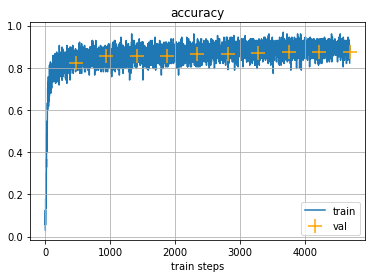

Epoch: 9, val loss: 0.3412122628356837, val accuracy: 0.8750988841056824


In [ ]:
model_sam = ConvNetFMNIST()
sam = SAM(model_sam.parameters(), torch.optim.SGD, lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sam, T_max=9)
train_fmnist_sam = TrainNet(model_sam, sam, batch_size, train_dataset_FMNIST, test_dataset_FMNIST, train_loader_FMNIST, test_loader_FMNIST, scheduler, True)

train_fmnist_sam.train(10)

In [ ]:
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O data.tar.gz
! tar -xzf data.tar.gz

--2021-10-06 09:40:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 162.60M  16.8MB/s    in 11s     

2021-10-06 09:40:58 (14.6 MB/s) - ‘data.tar.gz’ saved [170498071/170498071]



In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
data_path = "cifar-10-batches-py" 

In [ ]:
batchsize = 256

train_dataset_CIFAR = datasets.CIFAR10( data_path, train=True, download=True, transform=transform_train)
train_loader_CIFAR = torch.utils.data.DataLoader(train_dataset_CIFAR, batch_size=batchsize, shuffle=True, num_workers=2)

test_dataset_CIFAR = datasets.CIFAR10(data_path, train=False, download=True, transform=transform_test)
test_loader_CIFAR = torch.utils.data.DataLoader(test_dataset_CIFAR, batch_size=batchsize, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar-10-batches-py/cifar-10-python.tar.gz to cifar-10-batches-py
Files already downloaded and verified


In [ ]:
class ConvNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        
        self.classifier = nn.Linear(5 * 5 * 64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], 3, 32, 32)
        seq_out = self.features.forward(x)
        seq_out = seq_out.view(-1, 5 * 5 * 64)
        out = self.classifier(seq_out)
        return F.log_softmax(out, dim=-1)

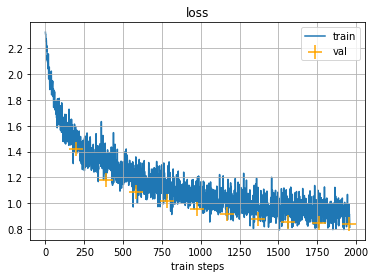

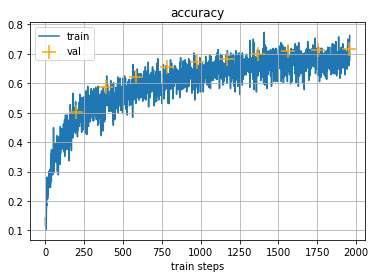

Epoch: 9, val loss: 0.8421620979905129, val accuracy: 0.717089831829071


In [ ]:
model_sgd = ConvNetCIFAR()
sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sgd, T_max=10)
train_cifar_sgd = TrainNet(model_sgd, sgd, batchsize, train_dataset_CIFAR, test_dataset_CIFAR, train_loader_CIFAR, test_loader_CIFAR, scheduler, False)

train_cifar_sgd.train(10)

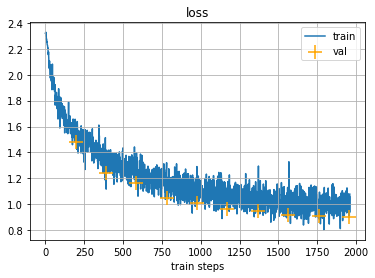

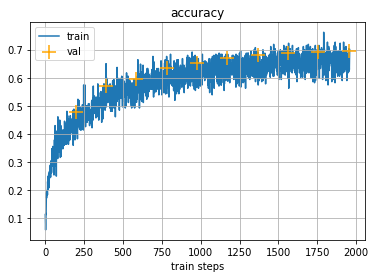

Epoch: 9, val loss: 0.9024241551756859, val accuracy: 0.6952148675918579


In [ ]:
model_sam = ConvNetCIFAR()
sam = SAM(model_sam.parameters(), torch.optim.SGD, lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sam, T_max=10)
train_cifar_sam = TrainNet(model_sam, sam, batchsize, train_dataset_CIFAR, test_dataset_CIFAR, train_loader_CIFAR, test_loader_CIFAR, scheduler, True)


train_cifar_sam.train(10)

In [ ]:
torch.save(train_cifar_sgd.model.state_dict(), "cifar_sgd")

In [ ]:
torch.save(train_cifar_sam.model.state_dict(), "cifar_sam")

In [ ]:
# https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


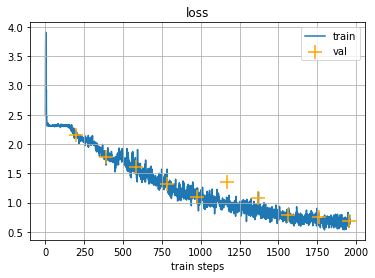

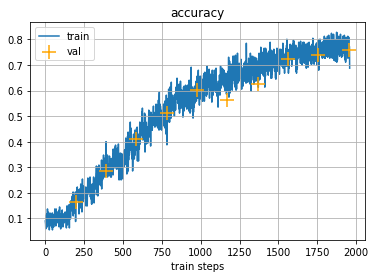

Epoch: 9, val loss: 0.6915736064314842, val accuracy: 0.7579101324081421


In [ ]:
resnet = ResNet(ResidualBlock, [2, 2, 2])
resnet = resnet.cuda()

sam = SAM(resnet.parameters(), torch.optim.SGD, lr=1.0, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sam, T_max=10)
train_cifar_sam = TrainNet(resnet, sam, batchsize, train_dataset_CIFAR, test_dataset_CIFAR, train_loader_CIFAR, test_loader_CIFAR, scheduler, True)


train_cifar_sam.train(10)

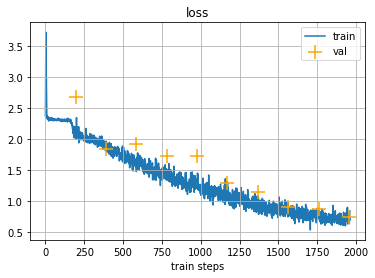

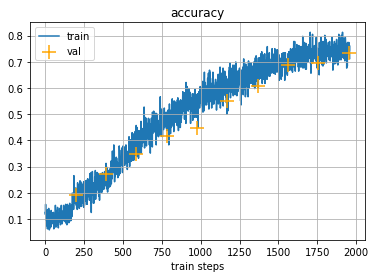

Epoch: 9, val loss: 0.7468883186578751, val accuracy: 0.7349609136581421


In [ ]:
resnet_sgd = ResNet(ResidualBlock, [2, 2, 2]).cuda()

sgd = torch.optim.SGD(resnet_sgd.parameters(), lr=1.0, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sgd, T_max=10)
train_cifar_sgd = TrainNet(resnet_sgd, sgd, batchsize, train_dataset_CIFAR, test_dataset_CIFAR, train_loader_CIFAR, test_loader_CIFAR, scheduler, False)

train_cifar_sgd.train(10)

In [ ]:
# Save model to plot loss near optimum
# Plot loss landscape: https://github.com/tomgoldstein/loss-landscape

torch.save(train_cifar_sgd.model.state_dict(), "resnet_sgd")

In [ ]:
torch.save(train_cifar_sam.model.state_dict(), "resnet_sam")